Problem statement: https://ovgu-ailab.github.io/lgm2021/ass9.html

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tensorflow.python.keras.layers.convolutional import Conv

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Number of GPUs Available: ",len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Number of GPUs Available:  1


11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
train_images[0] shape:  (28, 28)


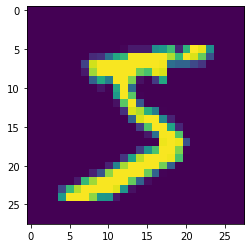

In [3]:
# Load MNIST Data set.
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_images.shape)
print(train_labels.shape)
print("train_images[0] shape: ",train_images[0].shape)
#show the first image.
plt.imshow(train_images[0])

In [4]:
def reshape_img(data):
  nsamples , nx , ny = data.shape
  return data.reshape(data.shape[0], nx, ny,1).astype(np.float32) / 255.0

In [5]:
train_img = reshape_img(train_images)
test_img = reshape_img(test_images)
print(train_img.shape)
#train_img = (train_img - 127.5) / 127.5  # Normalize the images to [-1, 1]
train_data = tf.data.Dataset.from_tensor_slices(train_img.astype(np.float32))
train_data = train_data.shuffle(buffer_size=60000).batch(128,drop_remainder=True)

print(test_img.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
input_shape = (28, 28, 1)

In [7]:
class MaskedConv2DTypeA(Conv):
  def __init__(self,
               filters,
               kernel_size,
               strides=1,
               padding='valid',
               data_format=None,
               dilation_rate=1,
               activation=None,
               use_bias=True,
               kernel_initializer='glorot_uniform',
               bias_initializer='zeros',
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               trainable=True,
               name=None,
               **kwargs):
    super(MaskedConv2DTypeA, self).__init__( 
               2,
               filters,
               kernel_size,
               strides=strides,
               padding=padding,
               data_format=data_format,
               dilation_rate=dilation_rate,
               activation=activation,
               use_bias=use_bias,
               kernel_initializer=kernel_initializer,
               bias_initializer='zeros',
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               trainable=True,
               name=None,
        **kwargs)
    if not isinstance(kernel_size, int):
        raise ValueError("Please specify kernel size as int")
    if kernel_size == 1:
        raise ValueError("Kernel size must be >1")
    if not (kernel_size % 2):
        raise ValueError("Odd kernel sizes only!")
        
    self.mask = np.zeros([kernel_size, kernel_size, 1, 1], dtype=np.float32)
    self.mask[:kernel_size//2, :, :, :] = 1
    self.mask[kernel_size//2, :kernel_size//2, :, : ] = 1
    self.mask = tf.convert_to_tensor(self.mask)
    
    
  def call(self, inputs):
    if self._recreate_conv_op(inputs):
      self._convolution_op = tf.python.ops.nn_ops.Convolution(
          inputs.get_shape(),
          filter_shape=self.kernel.shape,
          dilation_rate=self.dilation_rate,
          strides=self.strides,
          padding=self._padding_op,
          data_format=self._conv_op_data_format)

    # Apply causal padding to inputs for Conv1D.
    if self.padding == 'causal' and self.__class__.__name__ == 'Conv1D':
      inputs = tf.python.ops.array_ops.pad(inputs, self._compute_causal_padding())
    
    masked_kernel = self.mask * self.kernel
    outputs = self._convolution_op(inputs, masked_kernel)

    if self.use_bias:
      if self.data_format == 'channels_first':
        if self.rank == 1:
          # nn.bias_add does not accept a 1D input tensor.
          bias = tf.python.ops.array_ops.reshape(self.bias, (1, self.filters, 1))
          outputs += bias
        else:
          outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
      else:
        outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')

    if self.activation is not None:
      return self.activation(outputs)
    return outputs

In [8]:
# simple test whether it works without crashing
a = tf.random.normal([4, 16, 16, 3])
b = tf.keras.layers.Conv2D(32, 3, padding="same")(a)
c = MaskedConv2DTypeA(32, 3, padding="same")(a)

In [9]:
def get_model():
  inputs = tf.keras.Input(shape=input_shape)

  x = MaskedConv2DTypeA(128,7,padding="same",activation="relu")(inputs)
  for _ in range(3):
    x = MaskedConv2DTypeA(128,3,padding="same",activation="relu")(x)

  out = tf.keras.layers.Conv2D(
    filters=1, kernel_size=1, strides=1, padding="valid")(x)

  pixcel_cnn = tf.keras.Model(inputs, out)

  pixcel_cnn.summary()

  return pixcel_cnn



In [10]:
pixcel_cnn = get_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
masked_conv2d_type_a_1 (Mask (None, 28, 28, 128)       6400      
_________________________________________________________________
masked_conv2d_type_a_2 (Mask (None, 28, 28, 128)       147584    
_________________________________________________________________
masked_conv2d_type_a_3 (Mask (None, 28, 28, 128)       147584    
_________________________________________________________________
masked_conv2d_type_a_4 (Mask (None, 28, 28, 128)       147584    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 1)         129       
Total params: 449,281
Trainable params: 449,281
Non-trainable params: 0
_______________________________________________________

In [11]:
pixcel_cnn

In [12]:
epochs = 50
opt = tf.keras.optimizers.Adam(0.001)
loss_scc = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def pixelcnn_train(pixcel_cnn,loss):
  steps = 0
  for epoch in range(epochs):
    for img_batch in train_data:

      with tf.GradientTape() as tape:
        out = pixcel_cnn(img_batch)
        xent = loss(img_batch, out) #loss(img_batch, out)
        
      grads = tape.gradient(xent, pixcel_cnn.trainable_variables)
      opt.apply_gradients(zip(grads, pixcel_cnn.trainable_variables))

      #print("xent: ",xent)
      #print("grads: ",grads)
    
      steps += 1

      if steps % 100 == 0:
        print("Epoch:{}  Step:{} Loss:{}".format(epoch,steps,xent))


In [14]:
pixelcnn_train(pixcel_cnn,loss_bce)

Epoch:0  Step:100 Loss:0.1374504566192627
Epoch:0  Step:200 Loss:0.13509665429592133
Epoch:0  Step:300 Loss:0.12826435267925262
Epoch:0  Step:400 Loss:0.12569408118724823
Epoch:1  Step:500 Loss:0.1274586170911789
Epoch:1  Step:600 Loss:0.12159509211778641
Epoch:1  Step:700 Loss:0.12376789003610611
Epoch:1  Step:800 Loss:0.1230238676071167
Epoch:1  Step:900 Loss:0.1186741441488266
Epoch:2  Step:1000 Loss:0.11723092198371887
Epoch:2  Step:1100 Loss:0.11854238063097
Epoch:2  Step:1200 Loss:0.11775010824203491
Epoch:2  Step:1300 Loss:0.116533063352108
Epoch:2  Step:1400 Loss:0.11770745366811752
Epoch:3  Step:1500 Loss:0.12189804762601852
Epoch:3  Step:1600 Loss:0.12181808799505234
Epoch:3  Step:1700 Loss:0.11807321012020111
Epoch:3  Step:1800 Loss:0.11759837716817856
Epoch:4  Step:1900 Loss:0.11562541872262955
Epoch:4  Step:2000 Loss:0.12115247547626495
Epoch:4  Step:2100 Loss:0.11997871845960617
Epoch:4  Step:2200 Loss:0.11440002918243408
Epoch:4  Step:2300 Loss:0.11777295172214508
Epoch:

In [15]:
def generate_img(model,num, w, h):
    img = np.zeros([num, w, h, 1], dtype=np.float32)
    for row in range(w):
        for col in range(h):
            out = model(img)[:, row, col, :]
            out = tfp.distributions.Categorical(logits=out, dtype=tf.float32).sample()
            out = out / 255
            img[:, row, col, 0] = out
    return img 

In [16]:
images = generate_img(pixcel_cnn,5,28,28)

In [17]:
for img in images:
  print(img.shape)

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


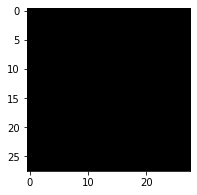

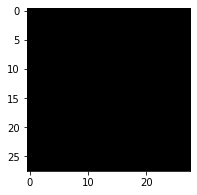

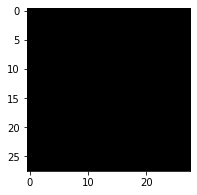

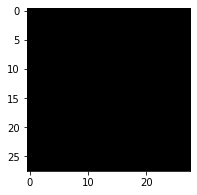

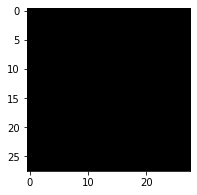

In [18]:
figsize = 3
for img in images:
  plt.figure(figsize=(figsize, figsize));
  img = img.reshape(28,28)
  plt.imshow(img,cmap='gray')
  plt.show()

In [19]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=1
        )
        self.pixel_conv = MaskedConv2DTypeA(filters=128,kernel_size=7,activation="relu",padding="same")
        self.conv2 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return tf.keras.layers.add([inputs, x])

In [20]:
def get_model_with_residual(num_res_block):
  inputs = tf.keras.Input(shape=input_shape)

  x = MaskedConv2DTypeA(filters=128,kernel_size=7,padding="same",activation="relu")(inputs)

  for _ in range(num_res_block):
    x = ResidualBlock(filters=128)(x)

  for _ in range(3):
    x = MaskedConv2DTypeA(128,3,padding="same",activation="relu")(x)

  out = tf.keras.layers.Conv2D(
    filters=1, kernel_size=1, strides=1, padding="valid")(x)

  pixcel_cnn = tf.keras.Model(inputs, out)

  pixcel_cnn.summary()
  
  return pixcel_cnn

In [21]:
pixcel_cnn_residual = get_model_with_residual(3)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
masked_conv2d_type_a_5 (Mask (None, 28, 28, 128)       6400      
_________________________________________________________________
residual_block (ResidualBloc (None, 28, 28, 128)       835968    
_________________________________________________________________
residual_block_1 (ResidualBl (None, 28, 28, 128)       835968    
_________________________________________________________________
residual_block_2 (ResidualBl (None, 28, 28, 128)       835968    
_________________________________________________________________
masked_conv2d_type_a_9 (Mask (None, 28, 28, 128)       147584    
_________________________________________________________________
masked_conv2d_type_a_10 (Mas (None, 28, 28, 128)       1475

In [22]:
pixelcnn_train(pixcel_cnn_residual,loss_bce)

Epoch:0  Step:100 Loss:0.29305005073547363
Epoch:0  Step:200 Loss:0.2076423019170761
Epoch:0  Step:300 Loss:0.17118214070796967
Epoch:0  Step:400 Loss:0.15536150336265564
Epoch:1  Step:500 Loss:0.1562470942735672
Epoch:1  Step:600 Loss:0.14722348749637604
Epoch:1  Step:700 Loss:0.1516205370426178
Epoch:1  Step:800 Loss:0.14243988692760468
Epoch:1  Step:900 Loss:0.13850881159305573
Epoch:2  Step:1000 Loss:0.12502029538154602
Epoch:2  Step:1100 Loss:0.12516282498836517
Epoch:2  Step:1200 Loss:0.12150990217924118
Epoch:2  Step:1300 Loss:0.12282241135835648
Epoch:2  Step:1400 Loss:0.12105391174554825
Epoch:3  Step:1500 Loss:0.11531759798526764
Epoch:3  Step:1600 Loss:0.11652294546365738
Epoch:3  Step:1700 Loss:0.117718406021595
Epoch:3  Step:1800 Loss:0.11381939798593521
Epoch:4  Step:1900 Loss:0.11685002595186234
Epoch:4  Step:2000 Loss:0.11998118460178375
Epoch:4  Step:2100 Loss:0.11461767554283142
Epoch:4  Step:2200 Loss:0.11204707622528076
Epoch:4  Step:2300 Loss:0.11016470193862915
Ep

In [23]:
images_res = generate_img(pixcel_cnn_residual,10,28,28)

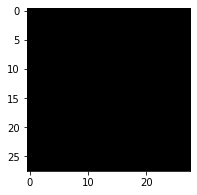

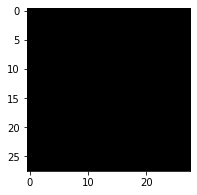

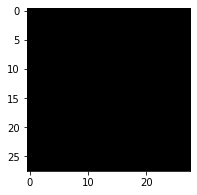

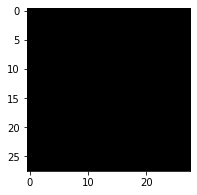

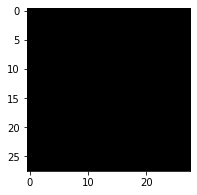

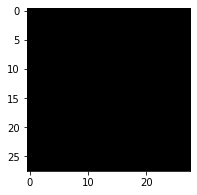

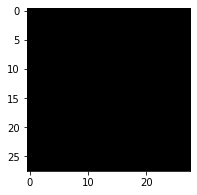

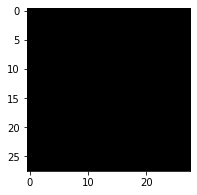

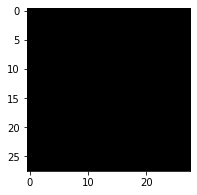

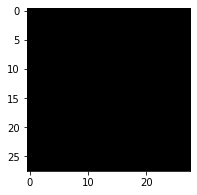

In [24]:
figsize = 3
for img in images_res:
  plt.figure(figsize=(figsize, figsize));
  img = img.reshape(28,28)
  plt.imshow(img,cmap='gray')
  plt.show()